In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Tue Jul 19 15:17:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/Rudrabha/Wav2Lip.git

Cloning into 'Wav2Lip'...
remote: Enumerating objects: 360, done.
remote: Total 360 (delta 0), reused 0 (delta 0), pack-reused 360
Receiving objects: 100% (360/360), 522.32 KiB | 18.65 MiB/s, done.
Resolving deltas: 100% (198/198), done.


In [ ]:
!pip uninstall tensorflow tensorflow-gpu

Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220527125636.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636


In [ ]:
pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 17.6 MB/s 


In [ ]:
import torch
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import random
import torchvision.transforms as transforms
from PIL import Image
from facenet_pytorch import MTCNN

In [ ]:
video_path = "/content/drive/MyDrive/Vision/Try/IMG_9951.MOV"

**Split video in frames**

In [ ]:
#split video in frames
vidcap = cv2.VideoCapture(video_path)

success,image = vidcap.read()
video = []
statistic = []
count = 0
while success:
  success, frame = vidcap.read()
  #cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  #success,image = vidcap.read()
  video.append(frame)
  statistic.append(success)
  #print('Read a new frame: ', success)
  count += 1


Number of frames on video:  357


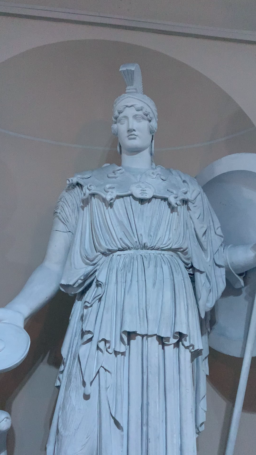

In [ ]:
#convert frames in tensor
t = transforms.ToPILImage()
cut = transforms.Compose([transforms.Resize(256), transforms.ToTensor()])

print('Number of frames on video: ', len(video))
#print(count)
#print(video[1])
image = t(video[0])
img = cut(image)
img = torch.rot90(img, 1, [2, 1]) #rotate image of 90 degrees to make it right (because .MOV video are rotated) [if use .mp4 doesn't need to rotate anything]
image = t(img)

display(image)


**Face detection**

In [ ]:
#face detector
mtcnn = MTCNN(keep_all=True, device='cuda') #cuda

In [ ]:
#check if there is a face
#(return 'False' if there isn't any face or if there is more than one face)

def check_faces(image):
  #t = transforms.ToPILImage()
  #cut = transforms.Compose([transforms.Resize(256), transforms.ToTensor()])
  #value = 0
  #for img in video_frames:
  '''img = t(img)
    img = cut(img)
    img = torch.rot90(img, 1, [2, 1]) #rotate image of 90 degrees to make it right (because .MOV video are rotated) [if use .mp4 doesn't need to rotate anything]
    image = t(img)'''
  image = image.convert('RGB')
  image_array = np.array(image, dtype=np.float32)
    # cv2 image color conversion
  image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
  bounding_boxes, conf = mtcnn.detect(image)
  if len(conf) == 1 and conf[0] > 0.59:
    return True
  else:
    return False

In [ ]:
face = check_faces(image)

In [ ]:
print(face)

True


In [ ]:
#if the def return false, the algorithm will stop, because can't produces an output in any cases
if not face:
  print('On the video there isn\'t any face or there are more than one, in both cases, the algorithm can\'t work. Please, do another video with a single face')

**Statue/Human classificator**

In [ ]:
#function to select random frames and classifier statue/human

def random_numbers(video_frames):
  number = []
  for i in range(0, 13):
    #print(random.randrange(0, len(video_frames)))
    number.append(random.randrange(0, len(video_frames)-2))
  return number

def select_random_frames(video_framse):
  number = random_numbers(video_framse)

  lista_video = []
  for i in number:
    lista_video.append(video[i])
  return lista_video
  
def classify_statue_human(video_frames):
  indices_to_labels = ['human', 'statue']
  result = [0,0] #11
  device = torch.device("cuda")
  t = transforms.ToPILImage()
  cut = transforms.Compose([transforms.Resize(256), transforms.ToTensor()])
  PATH = '/content/drive/MyDrive/Vision/Human_dataset/EfficientNet_back.pt'
  model_back = torch.load(PATH, map_location="cuda:0")
  model_back.to(device)
  model_back.eval()
  for img in video_frames:
    image = t(img)
    img = cut(image)
    img = torch.rot90(img, 1, [2, 1]) #rotate image of 90 degrees to make it right
    batch_t = torch.unsqueeze(img, 0)
    batch_t = batch_t.to(device)
    out = model_back(batch_t)
    _, index = torch.max(out, 1)
    #percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    index = index.item()
    #print(percentage[index].item())
    #if percentage[index].item() > 60 #set thrashold to 'Altro'
    result[index] += 1

  if result[0] >= 7:
    return indices_to_labels[0]
  else:
    return indices_to_labels[1]

In [ ]:
lista_video = select_random_frames(video) #random numbers

classe = classify_statue_human(lista_video)
print(classe)

#if the 'classify_statue_human' return human, the algorithm will stop.
if classe == 'human':
  print('The video represent a human, try again with a statue video (from Sapienza\'s Gipsoteca)')

statue


**Statue type classificator**

In [ ]:
#classifier function to classify wich statue is present on video
  
def classify_frames(video_frames):
  indices_to_labels = ['arringatore', 'atena', 'atena_armata', 'demostene', 'dioniso', 'era_barberini', 'ercole', 'kouros_da_tenea', 'minerva_tritonia', 'poseidone', 'zeus', 'altro']
  result = [0,0,0,0,0,0,0,0,0,0,0,0] #12
  device = torch.device("cuda")
  t = transforms.ToPILImage()
  cut = transforms.Compose([transforms.Resize(256), transforms.ToTensor()])
  PATH2 = '/content/drive/MyDrive/Vision/Dataset48/EfficientNet_new.pt'
  model = torch.load(PATH2, map_location="cuda:0")
  model.to(device)
  model.eval()
  for img in video_frames:
    image = t(img)
    img = cut(image)
    img = torch.rot90(img, 1, [2, 1]) #rotate image of 90 degrees to make it right
    batch_t = torch.unsqueeze(img, 0)
    batch_t = batch_t.to(device)
    out = model(batch_t)
    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    index = index.item()
    #print('Percentuale: ', percentage[index].item(), ' Classe: ', indices_to_labels[index])
    if percentage[index].item() < 82: #set thrashold to 'Altro'
      result[11] += 1
    else:
      result[index] += 1

  
  index = 0
  for i in range(0,len(result)):
    if  result[i] > result[index]:
      index = i
  print(result)
  return indices_to_labels[index]

In [ ]:
label = classify_frames(lista_video)
print(label)

[0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
atena


In [ ]:
#set audio path (based on label found)
audio = "/content/drive/MyDrive/Vision/Wav2Lip/" + label + ".mp4"
video_path = "/content/drive/MyDrive/Vision/Try/prova2.mp4"


**DeepFake**

In [ ]:
!cp -ri "/content/drive/MyDrive/Vision/Wav2lip/wav2lip_gan.pth" /content/Wav2Lip/checkpoints/
!cp -ri "/content/drive/MyDrive/Vision/Wav2lip/wav2lip.pth" /content/Wav2Lip/checkpoints/
!cd Wav2Lip && pip install -r requirements.txt
!wget "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" -O "Wav2Lip/face_detection/detection/sfd/s3fd.pth"

cp: overwrite '/content/Wav2Lip/checkpoints/wav2lip_gan.pth'? n
cp: overwrite '/content/Wav2Lip/checkpoints/wav2lip.pth'? n
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-07-19 15:26:02--  https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth
Resolving www.adrianbulat.com (www.adrianbulat.com)... 45.136.29.207
Connecting to www.adrianbulat.com (www.adrianbulat.com)|45.136.29.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89843225 (86M) [application/octet-stream]
Saving to: ‘Wav2Lip/face_detection/detection/sfd/s3fd.pth’

Wav2Lip/face_detect 100%[===================>]  85.68M  14.2MB/s    in 7.4s    

2022-07-19 15:26:10 (11.6 MB/s) - ‘Wav2Lip/face_detection/detection/sfd/s3fd.pth’ saved [89843225/89843225]



In [ ]:
!cd Wav2Lip && python inference.py --checkpoint_path checkpoints/wav2lip_gan.pth --face $video_path --audio $audio #--resize_factor 2 --nosmooth

Using cuda for inference.
Reading video frames...
Number of frames available for inference: 276
Extracting raw audio...
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvo

In [ ]:
#download the results
from google.colab import files
files.download('/content/Wav2Lip/results/result_voice.mp4')
mp4 = open('/content/Wav2Lip/results/result_voice.mp4','rb').read()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Credits

- https://github.com/Rudrabha/Wav2Lip
- https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
- https://github.com/NVlabs/ffhq-dataset
- Sapienza's Gipsoteca

<br></br>

Link Dataset used:
- Training set statues: https://drive.google.com/drive/folders/1KDm03tYHUkt9fzdbXXPIP47KZsIjDNha?usp=sharing
- Validation and Test set statues: https://drive.google.com/drive/folders/1ip6mCyUyNNupA2C4yh0xXiGE5nj9Cf_B?usp=sharing
- Humans Dataset: https://drive.google.com/drive/folders/1y93PGMy0u7GlheAGP-soClrGDqfgZscS?usp=sharing

(inside this repos, there are also weights for EfficientNet and tensor's dataset '.pt')
